# Productivity Group
OOI Data Labs Workshop - June 2019

**Working Title**: Chlorophyll-a in upwelling vs. stratified temperate regions

**Short Description**: 
Explore seawater characteristics that are correlated with changes in primary productivity, particularly during the summer in the North Pacific vs. the North Atlantic.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt

# Setup default plot styles
import seaborn as sns
sns.set()

## 1. Request Data from OOINet

* **Time range:** 2016-06-01 00:00:00 to 2017-09-01 00:00:00
* **Variables:** Chlorophyll, DO, Sewater Temperature, Salinity
* **Endurance** 
  * Oregon Offshore Surface Mooring, Dissolved Oxygen (CE04OSSM-RID27-04-DOSTAD000), recovered_host, dosta_abcdjm_dcl_instrument_recovered
  * Oregon Offshore Surface Mooring, 3-Wavelength Fluorometer (CE04OSSM-RID27-02-FLORTD000), recovered_host, flort_sample
* **Pioneer DO** 
  * Offshore Surface Mooring, Dissolved Oxygen (CP04OSSM-RID27-04-DOSTAD000), recovered_host, dosta_abcdjm_dcl_instrument_recovered
  * Offshore Surface Mooring, 3-Wavelength Fluorometer (CP04OSSM-RID27-02-FLORTD000), recovered_host, flort_sample
* Are these also needed?
  * CE northward wind (CE04OSSM-SBD11-06-METBKA000)
  * Coastal Endurance, Oregon Offshore Cabled Shallow Profiler Mooring, Dissolved Oxygen (CE04OSPS-SF01B-2A-CTDPFA107), streamed, ctdpf_sbe43_sample
    * Note: DO data is delivered in the CTD stream
    * Profiles of DO for the month before and the month during upwelling, approx. July 2016 and July 2017


In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# request_data('CE04OSSM-RID27-04-DOSTAD000','recovered_host','dosta_abcdjm_dcl_instrument_recovered',
#              '2016-06-01T00:00:00.000Z','2017-09-01T00:00:00.000Z')
# request_data('CE04OSSM-RID27-02-FLORTD000','recovered_host','flort_sample',
#              '2016-06-01T00:00:00.000Z','2017-09-01T00:00:00.000Z')
# request_data('CP04OSSM-RID27-04-DOSTAD000','recovered_host','dosta_abcdjm_dcl_instrument_recovered',
#              '2016-06-01T00:00:00.000Z','2017-09-01T00:00:00.000Z')
# request_data('CP04OSSM-RID27-02-FLORTD000','recovered_host','flort_sample',
#              '2016-06-01T00:00:00.000Z','2017-09-01T00:00:00.000Z')


## 2. Load Data Files

In [0]:
url_ce_do = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190712T171119433Z-CE04OSSM-RID27-04-DOSTAD000-recovered_host-dosta_abcdjm_dcl_instrument_recovered/catalog.html'
url_ce_flort = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190712T171134686Z-CE04OSSM-RID27-02-FLORTD000-recovered_host-flort_sample/catalog.html'
url_cp_do = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190712T171144709Z-CP04OSSM-RID27-04-DOSTAD000-recovered_host-dosta_abcdjm_dcl_instrument_recovered/catalog.html'
url_cp_flort = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190712T171158437Z-CP04OSSM-RID27-02-FLORTD000-recovered_host-flort_sample/catalog.html'


In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  # ds = ds.chunk({'time': 100}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

In [6]:
# Load the datasets Subset and resample
avgint = '1D'

ce_do = get_data(url_ce_do,'ctdbp')
ce_do = ce_do[['dissolved_oxygen','temp','practical_salinity']].load().resample(time=avgint).mean()

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 6959 times more chunks
  return self.array[key]


In [7]:
cp_do = get_data(url_cp_do,'ctdbp')
cp_do = cp_do[['dissolved_oxygen','temp','practical_salinity']].load().resample(time=avgint).mean()

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 10877 times more chunks
  return self.array[key]


In [8]:
ce_chl = get_data(url_ce_flort,'ctdbp')
ce_chl = ce_chl[['fluorometric_chlorophyll_a']].load().resample(time=avgint).mean()

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 10448 times more chunks
  return self.array[key]


In [9]:
cp_chl = get_data(url_cp_flort,'ctdbp')
cp_chl = cp_chl[['fluorometric_chlorophyll_a']].load().resample(time=avgint).mean()

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 18105 times more chunks
  return self.array[key]


## Plotting Fun

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


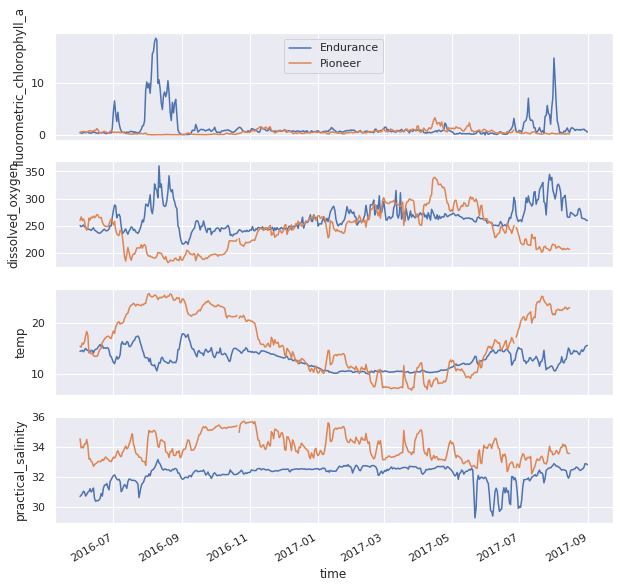

In [10]:
# Plot the data for the activity
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))

ce_chl.fluorometric_chlorophyll_a.plot(ax=ax1,label='Endurance')
ce_do.dissolved_oxygen.plot(ax=ax2)
ce_do.temp.plot(ax=ax3)
ce_do.practical_salinity.plot(ax=ax4)

cp_chl.fluorometric_chlorophyll_a.plot(ax=ax1,label='Pioneer')
cp_do.dissolved_oxygen.plot(ax=ax2)
cp_do.temp.plot(ax=ax3)
cp_do.practical_salinity.plot(ax=ax4)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('');

ax1.legend()

plt.savefig("productivity.png");

## 3. Merge and export

In [0]:
# Merge the datasets
a = ce_chl.rename({'fluorometric_chlorophyll_a':'Endurance Chlorophyll'})
b = ce_do.rename({'dissolved_oxygen':'Endurance DO',
                  'temp':'Endurnace Water Temp',
                  'practical_salinity':'Endurnace Salinity'
                 })
c = cp_chl.rename({'fluorometric_chlorophyll_a':'Pioneer Chlorophyll'})
d = cp_do.rename({'dissolved_oxygen':'Pioneer DO',
                  'temp':'Pioneer Water Temp',
                  'practical_salinity':'Pioneer Salinity'
                 })
x = xr.merge([a,b,c,d]).to_dataframe()

# Print the first few rows
# x.head()

In [0]:
# Export to CSV
x.to_csv('productivity.csv')

## Questions
* Do you want to show 2 variables at a time on the graph, and always showing chl?  We could also use 2-4 graphs to show all at once.
* How did you envision students looking at all 4 variables at once?
* How did you envision students comparing variables from 2 locations?
* Why did you ask for DO from Jan-Apr 2017 to be treated as missing data.
* Are you going to develop pages for the other parts of the LC, or just leave that in the instructors' guide?
* In the dataset section, you mentioend DO profiler data, but I don't see where that is used.
* Did you want all data available, or just a smaller range?  What are the red lines for in the ppt?  They don't match the requested range.
* Is all Pioneer temperature hidden to start, or just a section?
* Need background images and captions, as well as instructor guide.

